## Initialisations

In [ ]:
# initialisations
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind, ttest_rel
import random
from scipy.stats import chi2_contingency
from scipy.stats import chi2

In [ ]:
sns.set(
    palette="Paired",
    #style='whitegrid',
    color_codes=True,
    rc={"figure.figsize": (12,8)},
)

In [ ]:
url='https://drive.google.com/file/d/1Fsl9G_C7ZzRn0VpfpF8CjuXkdC18Y6Vf/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
compas_df = pd.read_csv(url, sep=',')
compas_df.head()

,Person_ID,AssessmentID,Case_ID,Agency_Text,LastName,FirstName,MiddleName,Sex_Code_Text,Ethnic_Code_Text,DateOfBirth,...,RecSupervisionLevel,RecSupervisionLevelText,Scale_ID,DisplayText,RawScore,DecileScore,ScoreText,AssessmentType,IsCompleted,IsDeleted
0,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,7,Risk of Violence,-2.08,4,Low,New,1,0
1,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,8,Risk of Recidivism,-1.06,2,Low,New,1,0
2,50844,57167,51950,PRETRIAL,Fisher,Kevin,NaN,Male,Caucasian,12/05/92,...,1,Low,18,Risk of Failure to Appear,15.00,1,Low,New,1,0
3,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,7,Risk of Violence,-2.84,2,Low,New,1,0
4,50848,57174,51956,PRETRIAL,KENDALL,KEVIN,NaN,Male,Caucasian,09/16/84,...,1,Low,8,Risk of Recidivism,-1.50,1,Low,New,1,0


In [ ]:
import os
import warnings
from plotly.subplots import make_subplots
import pickle
import plotly.graph_objects as go
import plotly.express as px
from sklearn import svm
from sklearn import tree
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score
from sklearn.metrics import *
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from math import sqrt
pd.set_option('display.max_columns',None)
warnings.filterwarnings('ignore')

## Preprocessing

In [ ]:
# Data was collected in 2016 therefore age can be determined
# Remove unneccessary month day information- since the age will be from the last minute of 2016
compas_df['DateOfBirth'] = compas_df['DateOfBirth'].str[6:]
# convert to integer and add 1900
compas_df['DateOfBirth'] = pd.to_numeric(compas_df['DateOfBirth'])
compas_df['DateOfBirth'] = compas_df['DateOfBirth'] + 1900

In [ ]:
# create new age column
compas_df["Age"] = 2016 - compas_df["DateOfBirth"]

In [ ]:
compas_df['ScoreText'].replace('High', 'Medium_High', inplace=True)
compas_df['ScoreText'].replace('Medium', 'Medium_High', inplace=True)

In [ ]:
compas_df = compas_df.drop(columns=["Person_ID","AssessmentID","Case_ID","FirstName","MiddleName","LastName","DateOfBirth","ScaleSet_ID","Screening_Date","AssessmentReason","RecSupervisionLevel","Scale_ID","IsCompleted","IsDeleted"])

In [ ]:
# remove the columns RawScore, DecileScore and RecSupervisionLevelText as they give the model the answer by themselves
compas_df = compas_df.drop(columns=["DecileScore","RecSupervisionLevelText","RawScore"])

In [ ]:
compas_df.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,ScoreText,AssessmentType,Age
0,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Violence,Low,New,24
1,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Recidivism,Low,New,24
2,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Single,Risk of Failure to Appear,Low,New,24
3,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Violence,Low,New,32
4,PRETRIAL,Male,Caucasian,Risk and Prescreen,English,Pretrial,Jail Inmate,Married,Risk of Recidivism,Low,New,32


In [ ]:
compas_df.dtypes

Agency_Text         object
Sex_Code_Text       object
Ethnic_Code_Text    object
ScaleSet            object
Language            object
LegalStatus         object
CustodyStatus       object
MaritalStatus       object
DisplayText         object
ScoreText           object
AssessmentType      object
Age                  int64
dtype: object

In [ ]:
for col in compas_df:
    print(col)
    print(compas_df[col].nunique())
    print(compas_df[col].unique())

Agency_Text
4
['PRETRIAL' 'Probation' 'DRRD' 'Broward County']
Sex_Code_Text
2
['Male' 'Female']
Ethnic_Code_Text
9
['Caucasian' 'African-American' 'Hispanic' 'Other' 'Asian' 'African-Am'
 'Native American' 'Oriental' 'Arabic']
ScaleSet
2
['Risk and Prescreen' 'All Scales']
Language
2
['English' 'Spanish']
LegalStatus
7
['Pretrial' 'Post Sentence' 'Conditional Release' 'Other'
 'Probation Violator' 'Parole Violator' 'Deferred Sentencing']
CustodyStatus
6
['Jail Inmate' 'Probation' 'Pretrial Defendant' 'Residential Program'
 'Prison Inmate' 'Parole']
MaritalStatus
7
['Single' 'Married' 'Significant Other' 'Divorced' 'Separated' 'Widowed'
 'Unknown']
DisplayText
3
['Risk of Violence' 'Risk of Recidivism' 'Risk of Failure to Appear']
ScoreText
2
['Low' 'Medium_High' nan]
AssessmentType
2
['New' 'Copy']
Age
71
[24 32 22 31 50 23 44 30 36 38 28 37 46 25 41 43 35 27 56 49 61 42 29 73
 39 33 48 34 45 57 69 54 26 51 53 52 72 62 63 60 83 55 47 20 40 66 58 74
 59 65 87 21 70 68 71 76 67 64 78 79

In [ ]:
compas_df.shape[0]

60843

In [ ]:
compas_df = compas_df.dropna()

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Unknown']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Other']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Oriental']

In [ ]:
for col in compas_df:
    compas_df = compas_df[compas_df[col] != 'Arabic']

In [ ]:
compas_df.shape[0]

53628

In [ ]:
compas_df['ScoreText'].unique()

array(['Low', 'Medium_High'], dtype=object)

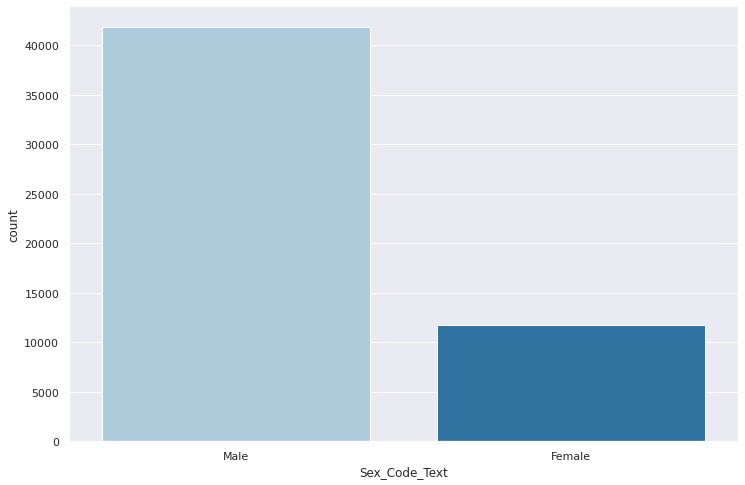

In [ ]:
sns.countplot(data=compas_df,x='Sex_Code_Text')

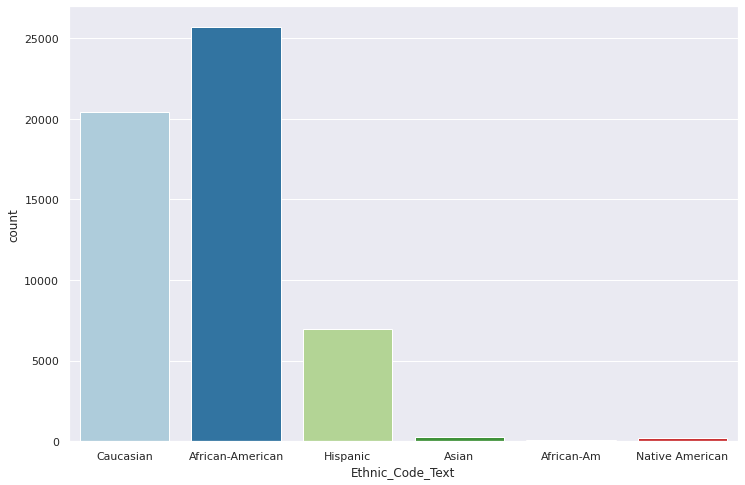

In [ ]:
sns.countplot(data=compas_df,x='Ethnic_Code_Text')

In [ ]:
compas_df['Ethnic_Code_Text'].replace('African-Am', 'African-American', inplace=True)

In [ ]:
compas_df.groupby('Ethnic_Code_Text',sort=False).size()

Ethnic_Code_Text
Caucasian           20436
African-American    25743
Hispanic             6960
Asian                 291
Native American       198
dtype: int64

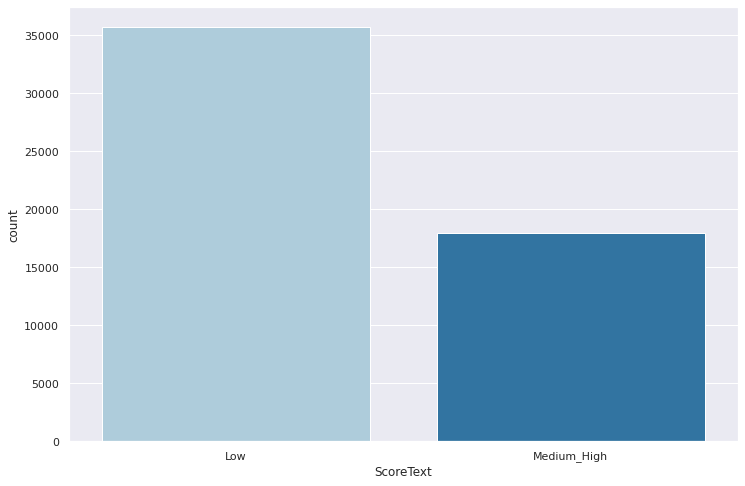

In [ ]:
sns.countplot(data=compas_df,x='ScoreText')

In [ ]:
compas_df.ScoreText.value_counts()

Low            35671
Medium_High    17957
Name: ScoreText, dtype: int64

Label Encoder

What is a label encoder? Image result for label encoder Label Encoding is a popular encoding technique for handling categorical variables. In this technique, each label is assigned a unique integer based on alphabetical ordering

In [ ]:
le = LabelEncoder()
compas_df.Agency_Text = le.fit_transform(compas_df.Agency_Text)
compas_df.Sex_Code_Text = le.fit_transform(compas_df.Sex_Code_Text)
compas_df.Ethnic_Code_Text = le.fit_transform(compas_df.Ethnic_Code_Text)
compas_df.ScaleSet = le.fit_transform(compas_df.ScaleSet)
compas_df.Language = le.fit_transform(compas_df.Language)
compas_df.LegalStatus = le.fit_transform(compas_df.LegalStatus)
compas_df.CustodyStatus = le.fit_transform(compas_df.CustodyStatus)
compas_df.MaritalStatus = le.fit_transform(compas_df.MaritalStatus)
compas_df.DisplayText = le.fit_transform(compas_df.DisplayText)
compas_df.ScoreText = le.fit_transform(compas_df.ScoreText)
compas_df.AssessmentType = le.fit_transform(compas_df.AssessmentType)

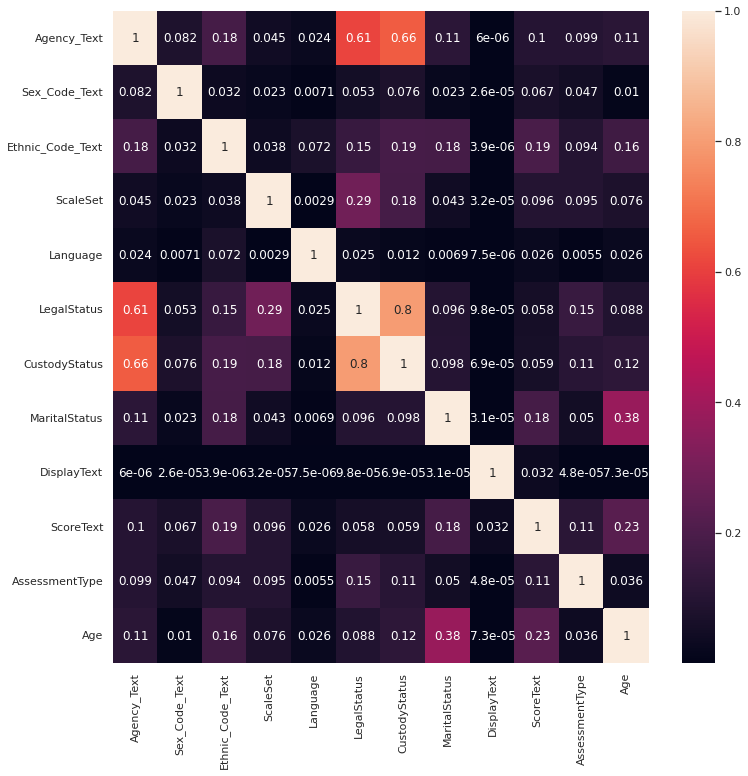

In [ ]:
plt.figure(figsize=(12,12))
map = sns.heatmap(compas_df.corr().abs(),annot=True)

In [ ]:
compas_df.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,ScoreText,AssessmentType,Age
0,2,1,2,1,0,4,0,4,2,0,1,24
1,2,1,2,1,0,4,0,4,1,0,1,24
2,2,1,2,1,0,4,0,4,0,0,1,24
3,2,1,2,1,0,4,0,1,2,0,1,32
4,2,1,2,1,0,4,0,1,1,0,1,32


## Test Train Split

In [ ]:
X = compas_df.drop('ScoreText',axis=1)
y = compas_df[['ScoreText']]

K-Fold

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

In [ ]:
print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(35752, 11)
Test data shape:(17876, 11)


Scaling data

In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

In [ ]:
x_train.head()

,Agency_Text,Sex_Code_Text,Ethnic_Code_Text,ScaleSet,Language,LegalStatus,CustodyStatus,MaritalStatus,DisplayText,AssessmentType,Age
0,2,1,2,1,0,4,0,4,2,1,24
2,2,1,2,1,0,4,0,4,0,1,24
4,2,1,2,1,0,4,0,1,1,1,32
5,2,1,2,1,0,4,0,1,0,1,32
6,2,1,0,1,0,4,0,4,2,1,22


In [ ]:
x_train.shape[0]

35752

In [ ]:
x_test.shape[0]

17876

In [ ]:
y_test.shape[0]

17876

## kNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=3)

In [ ]:
knn_model.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=3)

In [ ]:
pred = knn_model.predict(x_test)

In [ ]:
knnaccuracy = accuracy_score(y_test, pred)

In [ ]:
parameters = {"n_neighbors": range(1, 200, 4)}
gridsearch = GridSearchCV(KNeighborsClassifier(), parameters)
gridsearch.fit(x_train, y_train)

GridSearchCV(estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': range(1, 200, 4)})

In [ ]:
gridsearch.best_params_

{'n_neighbors': 81}

In [ ]:
knn_model_tuned = KNeighborsClassifier(n_neighbors=81)

In [ ]:
knn_model_tuned.fit(x_train, y_train)

KNeighborsClassifier(n_neighbors=81)

In [ ]:
pred = knn_model_tuned.predict(x_test)

In [ ]:
knntaccuracy = accuracy_score(y_test, pred)

## Support Vector Machine

SVM is another algorithm for classifying data. It tries to divide the data up using lines, sometimes straight linear lines and sometimes curved lines.

SVM tries to find the best lines - actually, a plane in multiple dimensions - to divide the data up into the known categories.

### Linear SVM

In [ ]:
#Create a svm Classifier
svmclf = svm.SVC(kernel='linear') # Linear Kernel

#Train the model using the training sets
svmclf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = svmclf.predict(x_test)

In [ ]:
# Model Accuracy
svmlaccuracy = metrics.accuracy_score(y_test, y_pred)
svmlaucscore = roc_auc_score(y_test, pred)
print("Overall AUC on validation: {:.3f}" .format(svmlaucscore))

Overall AUC on validation: 0.664


### Non linear SVM

In [ ]:
#Create a svm Classifier
svmclf = svm.SVC(kernel='rbf') # Non-Linear Kernel

#Train the model using the training sets
svmclf.fit(x_train, y_train)

#Predict the response for test dataset
y_pred = svmclf.predict(x_test)

In [ ]:
# Model Accuracy
svmnlaccuracy = metrics.accuracy_score(y_test, y_pred)
svmnlaucscore = roc_auc_score(y_test, pred)
print("Overall AUC on validation: {:.3f}" .format(svmnlaucscore))

Overall AUC on validation: 0.664


## Decision Tree Model

The Decision-Tree algorithm is one of the most frequently and widely used supervised machine learning algorithms that can be used for both classification and regression tasks.

The intuition behind the Decision-Tree algorithm is very simple to understand.

The Decision Tree algorithm intuition is as follows:-
For each attribute in the dataset, the Decision-Tree algorithm forms a node. The most important attribute is placed at the root node.

For evaluating the task in hand, we start at the root node and we work our way down the tree by following the corresponding node that meets our condition or decision.

This process continues until a leaf node is reached. It contains the prediction or the outcome of the Decision Tree.

In [ ]:
dt = DecisionTreeClassifier()

In [ ]:
dt.fit(scaled_train,y_train)

DecisionTreeClassifier()

In [ ]:
pred = dt.predict(scaled_test)

In [ ]:
dtaccuracy = accuracy_score(y_test,pred)

In [ ]:
param_grid = {'criterion': ['gini', 'entropy'],  #scoring methodology; two supported formulas for calculating information gain - default is gini
              'splitter': ['best', 'random'], #splitting methodology; two supported strategies - default is best
              'max_depth': [2,4,6,8,10,None], #max depth tree can grow; default is none
              'min_samples_split': [2,5,10,.03,.05], #minimum subset size BEFORE new split (fraction is % of total); default is 2
              'min_samples_leaf': [1,5,10,.03,.05], #minimum subset size AFTER new split split (fraction is % of total); default is 1
              'max_features': [None, 'auto'], #max features to consider when performing split; default none or all
              'random_state': [0] #seed or control random number generator
             }

In [ ]:
tune_model = GridSearchCV(DecisionTreeClassifier(), 
                          param_grid=param_grid, 
                          scoring = 'roc_auc',
                          cv = 5,
                          verbose=0)
tune_model.fit(scaled_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, None],
                         'max_features': [None, 'auto'],
                         'min_samples_leaf': [1, 5, 10, 0.03, 0.05],
                         'min_samples_split': [2, 5, 10, 0.03, 0.05],
                         'random_state': [0], 'splitter': ['best', 'random']},
             scoring='roc_auc')

In [ ]:
print('\033[1m'+'Decision Tree Parameters:{} '.format(tune_model.best_params_))

Decision Tree Parameters:{'criterion': 'gini', 'max_depth': 8, 'max_features': None, 'min_samples_leaf': 10, 'min_samples_split': 2, 'random_state': 0, 'splitter': 'random'} 


In [ ]:
dt_tuned =  DecisionTreeClassifier(criterion='gini',
                                   min_samples_split=2,
                                   max_depth=8,
                                   max_features = None,
                                   min_samples_leaf=10,
                                   random_state = 0,
                                   splitter='random')

dt_tuned.fit(scaled_train,y_train)

DecisionTreeClassifier(max_depth=8, min_samples_leaf=10, random_state=0,
                       splitter='random')

In [ ]:
pred = dt_tuned.predict(scaled_test)

In [ ]:
dttaccuracy = accuracy_score(y_test,pred)

## Test-Train Split

In [ ]:
X = compas_df.drop('ScoreText',axis=1)
y = compas_df[['ScoreText']]

In [ ]:
KF = StratifiedKFold(n_splits=3,shuffle=True,random_state=64)
for train_index, test_index in KF.split(X, y):
    x_train, x_test = X.iloc[list(train_index)], X.iloc[list(test_index)]
    y_train, y_test = y.iloc[list(train_index)], y.iloc[list(test_index)]

print("Train data shape:{}".format(x_train.shape))
print("Test data shape:{}".format(x_test.shape))

Train data shape:(35752, 11)
Test data shape:(17876, 11)


In [ ]:
scaler = MinMaxScaler()
scaled_train = scaler.fit_transform(x_train)
scaled_test = scaler.transform(x_test)

## Random Forest

In [ ]:
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(x_train,y_train)

RandomForestClassifier(max_depth=2, random_state=0)

In [ ]:
pred=clf.predict(x_test)

In [ ]:
rfaccuracy = metrics.accuracy_score(y_test, pred)

## Gradient Boosting

In [ ]:
gbclf = GradientBoostingClassifier()
gbclf.fit(x_train, y_train)

GradientBoostingClassifier()

In [ ]:
pred = gbclf.predict(x_test)

In [ ]:
gbaccuracy = metrics.accuracy_score(y_test, pred)

## Model Comparison

In [ ]:
from tabulate import tabulate
data = [['kNN', knnaccuracy],
['kNN with Grid Search', knntaccuracy],
['Support Vector Machine (Linear)', svmlaccuracy],
['Support Vector Machine (Non-Linear)', svmnlaccuracy],
['Decision Tree', dtaccuracy],
['Decision Tree with Grid Search', dttaccuracy],
['Random Forest', rfaccuracy],
['Gradient Boosting Ensemble', gbaccuracy],
]
print (tabulate(data, headers=["Machine Learning Model", "Classification Accuracy"]))

Machine Learning Model                 Classification Accuracy
-----------------------------------  -------------------------
kNN                                                   0.710897
kNN with Grid Search                                  0.746252
Support Vector Machine (Linear)                       0.67034
Support Vector Machine (Non-Linear)                   0.719232
Decision Tree                                         0.725106
Decision Tree with Grid Search                        0.746979
Random Forest                                         0.672913
Gradient Boosting Ensemble                            0.756489
